<a href="https://colab.research.google.com/github/tehZevo/pokemon-map-vae/blob/master/Pokemon_Map_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Pokemon maps with a VAE

### Some of the process so far:
* found map
* measured map (oh god trees)
  * shrunk map down by 16x to count pixels..
* no area seems to be smaller than 24x20 tiles
* map seems aligned to a grid of 12x10 tiles
* tried image hashing.. too many (funny) collisions.. decided to use built in python hash
* gotta usea consistent datatypes for numpy arrays (uint8) because hash changes when dtype changes (obviously)

gba res is 240x160 pixels

TODO
*  sevii islands?
* add bounding boxes for routes
* try "warming up" the vae (0 kl loss, and slowly add kl loss)
  * make kl weight an adjustable parameter

## Setup and loading

### Imports

In [21]:
#https://medium.com/@mmmulani/creating-a-game-size-world-map-of-pok%C3%A9mon-fire-red-614da729476a
  
#https://i.imgur.com/spz3zUx.png

!pip install imagehash

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import imagehash
from PIL import Image

from IPython.display import clear_output

%matplotlib inline



### Load world map


In [3]:
#upload map
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving wholemap.png to wholemap.png
User uploaded file "wholemap.png" with length 1828114 bytes


In [0]:
#open and convert from bgr to rgb
whole_map = cv2.imread("wholemap.png")
whole_map = whole_map[...,::-1] #convert bgr->rgb

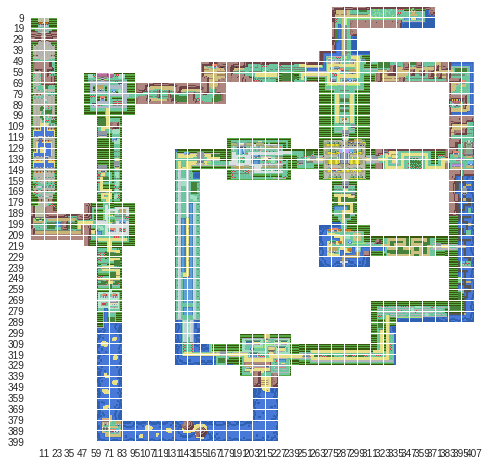

In [10]:
#scale down and show smaller version
small_map = cv2.resize(whole_map, None, fx=1/16, fy=1/16)
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(-1, small_map.shape[1], 12))
ax.yaxis.set_ticks(np.arange(-1, small_map.shape[0], 10))
plt.imshow(small_map)
plt.show()

## Dataset creation

### Define bounding boxes
bounding boxes are measured in tiles

In [0]:
#define bounding boxes to grab from the "whole map"
#exclusive x2, y2... kthx
bbs = [
    #big cities
    (48, 180, 96, 220), #viridian city
    (48, 60, 96, 100), #pewter city?
    (264, 40, 312, 80), #cerulean city
    (264, 120, 312, 160), #saffron city
    (264, 200, 312, 240), #vermillion city
    (180, 120, 240, 160), #celadon city
    (192, 300, 240, 340), #fuschia city
]

#plot all bounding boxes
# for bb in bbs:
#   x1, y1, x2, y2 = [e * 16 for e in bb]
#   print(x1, y1, x2, y2)
#   print(x2 - x1, y2 - y1)
#   im = whole_map[y1:y2, x1:x2]
#   plt.figure(figsize=(8, 8))
#   plt.imshow(im)
#   ax = plt.gca()
#   #ax.xaxis.set_ticks(np.arange(-1, im.shape[1], 16))
#   ax.xaxis.set_ticks(np.arange(-1, im.shape[1], 12 * 16))
#   #ax.yaxis.set_ticks(np.arange(-1, im.shape[0], 16))
#   ax.yaxis.set_ticks(np.arange(-1, im.shape[0], 10 * 16))
#   plt.show()

### Build tileset
Hash each tile in each bounding box, create mapping from hash to tile

total tiles: 976


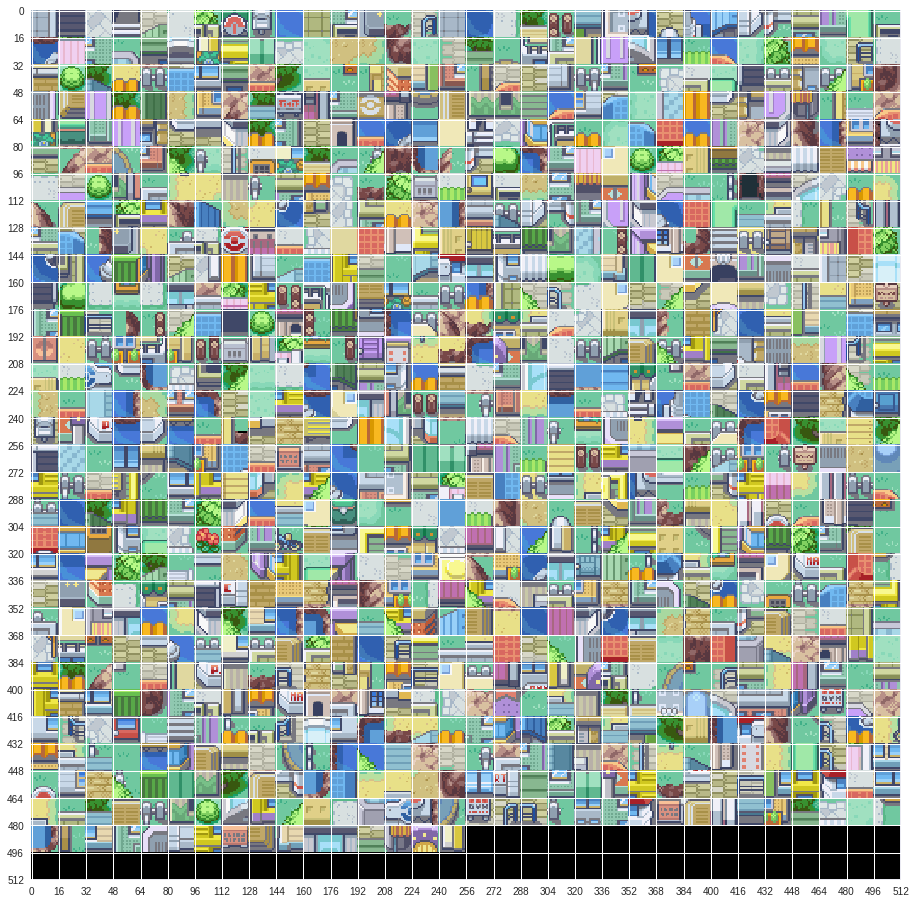

In [36]:
def hash_tile(tile):
  #return imagehash.average_hash(Image.fromarray(tile.astype('uint8'), 'RGB'))
  #return imagehash.phash(Image.fromarray(tile.astype('uint8'), 'RGB'))
  return str(hash(tile.astype("uint8").tostring())) #just using regular hashing...

tile_hashes = dict()

#for each bounding box
for bb in bbs:
  x1, y1, x2, y2 = bb
  #for each tile in the bounding box
  bb_w = x2 - x1
  bb_h = y2 - y1
  for x in range(bb_w):
    for y in range(bb_h):
      #grab tile (16x16 range) and calculate hash
      tile = whole_map[(y1+y)*16:(y1+y+1)*16, (x1+x)*16:(x1+x+1)*16]
      tile_hash = hash_tile(tile)
      #if we haven't seen the hash before, add the hash->image mapping
      if tile_hash not in tile_hashes:
        #print("added hash {}".format(tile_hash))
        tile_hashes[tile_hash] = tile

hash_list = sorted(list(tile_hashes.keys()))

print("total tiles: {}".format(len(tile_hashes.items())))

#plot all tiles in hash index order
disp_size = math.ceil(math.sqrt(len(tile_hashes.items())))
area = np.zeros((disp_size * 16, disp_size * 16, 3), "uint8")

plt.figure(figsize=(16, 16))
for i, tile_hash in enumerate(hash_list):
  x = i % disp_size
  y = math.floor(i / disp_size)
  tile = tile_hashes[tile_hash]
  area[y*16:(y+1)*16, x*16:(x+1)*16] = tile

plt.imshow(area)
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, area.shape[1] + 16, 16))
ax.yaxis.set_ticks(np.arange(0, area.shape[0] + 16, 16))
plt.show()

### Utility functions for encoding/decoding chunks/tiles

In [0]:
#use uint8 for encoding too.. might as well use bytes since bools are stored as bytes too
def encode_tile(tile):
  h = hash_tile(tile)
  i = hash_list.index(h) #TODO: catch missing hash?
  r = np.zeros(len(hash_list), "uint8")
  r[i] = 1
  return r

def decode_tile(x):
  x = np.argmax(x)
  x = hash_list[x]
  tile = tile_hashes[x]
  return tile

def encode_chunk(chunk):
  w = int(chunk.shape[1] / 16)
  h = int(chunk.shape[0] / 16)
  encoded_chunk = np.zeros((h, w, len(hash_list)), "uint8")
  for x in range(w):
    for y in range(h):
      tile = chunk[y*16:(y+1)*16, x*16:(x+1)*16]
      encoded_chunk[y, x] = encode_tile(tile)
  return encoded_chunk

def decode_chunk(chunk):
  w = chunk.shape[1]
  h = chunk.shape[0]
  decoded_chunk = np.zeros((h * 16, w * 16, 3), "uint8")
  for x in range(w):
    for y in range(h):
      tile = chunk[y, x]
      decoded_chunk[y*16:(y+1)*16, x*16:(x+1)*16] = decode_tile(tile)
  return decoded_chunk

### Create dataset
Dataset will be randomly selected areas of `chunk_w` by `chunk_h` tiles

In [38]:
#define chunk size in tiles (most areas in the map are evenly divisible by this number of tiles)
#most areas are evenly divisible by chunks of 12x10 tiles, so multiples of this should work well
#max of 24x20 for routes, 48x40 for cities i think
chunk_w = 24 #try 24x16 or 16x16 with 3 conv #also needs to have high divisibility by 2 for more convs :^)
chunk_h = 16
num_chunks = 1000

#create our dataset of "chunks"
chunks = []

for i in range(num_chunks):
  #pick a random bounding box
  x1, y1, x2, y2 = bbs[np.random.choice(range(len(bbs)))]
  w = x2 - x1
  h = y2 - y1
  #pick a random chunk within that bounding box
  tx = np.random.randint(x1, x2 - chunk_w)
  ty = np.random.randint(y1, y2 - chunk_h)
  #TODO: get chunk from whole map
  chunk = whole_map[ty*16:(ty+chunk_h)*16, tx*16:(tx+chunk_w)*16]
  chunks.append(chunk)
  if (i + 1) % (num_chunks / 100) == 0:
    clear_output()
    print("Creating chunks... ({}%)".format((i + 1) / num_chunks * 100))

#encode each chunk
print("Encoding chunks...")
encoded_chunks = [encode_chunk(chunk) for chunk in chunks]

#decode each chunk for testing purposes
# print("Decoding chunks...")
# decoded_chunks = [decode_chunk(chunk) for chunk in encoded_chunks]

#plot a random decoded chunk
# chunk = decoded_chunks[np.random.choice(range(len(decoded_chunks)))]
# plt.figure(figsize=(8, 8))
# plt.imshow(chunk.astype("uint8"))
# ax = plt.gca()
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# plt.show()

print("Done")

Creating chunks... (100.0%)
Encoding chunks...
Done


## Create and train VAE

### VAE builder functions

In [39]:
from keras.losses import mse, categorical_crossentropy, binary_crossentropy #binary for mnist testing
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
from keras.utils import plot_model

def sampling(args):
  z_mean, z_log_sigma = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dim))
  
  return z_mean + K.exp(z_log_sigma) * epsilon

#supposedly keras uses the last dimension for softmax/crossentropy
#builds vae loss function with the given reconstruction loss function
def build_loss_function(z_mean, z_log_sigma, reconstruction_loss_function):
  def vae_loss(x, x_decoded_mean):
    reconstruction_loss = reconstruction_loss_function(x, x_decoded_mean)
    reconstruction_loss = K.mean(reconstruction_loss)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    #return xentLoss + kl_loss
    kl_scale = 0.1 #TODO: make parameter, also make adjustable by recompiling (loss function)
    return reconstruction_loss + kl_loss * kl_scale
  return vae_loss

def build_conv_vae(input_shape, filters, latent_dim, acti="relu", out_acti="softmax", opti="adam", rec_loss=categorical_crossentropy):
  len_input = np.prod(input_shape)
  
  #build encoder
  encoder_input = Input(shape=input_shape)
  x = encoder_input
  for num_filters in filters:
    x = Conv2D(num_filters, (3, 3), activation=acti, padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
  #save shape to resize for decoder
  inner_conv_dim = x.shape.as_list()[1:] #skip batch dim
  intermediate_dim = np.prod(inner_conv_dim)
  print(x.shape, inner_conv_dim, intermediate_dim)
  x = Flatten()(x) #flatten in functional api gives (?, ?) for shape...
  z_mean = Dense(latent_dim)(x)
  z_log_sigma = Dense(latent_dim)(x)
  z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
  encoder = Model(encoder_input, [z_mean, z_log_sigma, z])
  
  #build decoder
  decoder_input = Input(shape=(latent_dim,))
  x = decoder_input
  x = Dense(intermediate_dim, activation=acti)(x)
  #reshape to fit initial conv size
  x = Reshape(inner_conv_dim)(x)
  for num_filters in reversed(filters):
    x = Conv2D(num_filters, (3, 3), activation=acti, padding="same")(x)
    x = UpSampling2D((2, 2))(x)
  decoder_output = Conv2D(input_shape[-1], (3, 3), activation=out_acti, padding="same")(x)
  decoder = Model(decoder_input, decoder_output)
  
  #link encoder and decoder to build vae
  vae_outputs = decoder(encoder(encoder_input)[2])
  vae = Model(encoder_input, vae_outputs)
  #categorical crossentropy for pixelwise tile prediction
  vae_loss = build_loss_function(z_mean, z_log_sigma, rec_loss)
  vae.compile(optimizer=opti, loss=vae_loss)
  return (vae, encoder, decoder)

def build_vae(input_shape, intermediate_dim, latent_dim):
  len_input = np.prod(input_shape)
  
  #build encoder
  inputs = Input(shape=input_shape)
  x = inputs
  x = Flatten()(x)
  x = Dense(intermediate_dim, activation="relu")(x)
  z_mean = Dense(latent_dim)(x)
  z_log_sigma = Dense(latent_dim)(x)
  z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
  encoder = Model(inputs, [z_mean, z_log_sigma, z], name="encoder")
  
  #build decoder
  latent_input = Input(shape=(latent_dim,))
  x = Dense(intermediate_dim, activation="relu")(latent_input)
  x = Dense(len_input, activation="sigmoid")(x)
  x = Reshape(input_shape)(x)
  decoder_output = x
  decoder = Model(latent_input, decoder_output, name="decoder")
  
  #link encoder and decoder to build vae
  vae_outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, vae_outputs, name="vae")
  
  #categorical crossentropy for pixelwise tile prediction
  #vae_loss = build_loss_function(z_mean, z_log_sigma, categorical_crossentropy)
  #vae_loss = build_loss_function(z_mean, z_log_sigma, binary_crossentropy)
  vae_loss = build_loss_function(z_mean, z_log_sigma, mse)
  #vae.compile(optimizer="rmsprop", loss=vae_loss)
  vae.compile(optimizer="adam", loss=vae_loss)
  return (vae, encoder, decoder)

Using TensorFlow backend.


### Create VAE

In [40]:
#free old layers, etc so they dont stack up when rerunning this cell
K.clear_session()

x_train = np.array(encoded_chunks)
intermediate_dim = 512 #only for dense vae
conv_filters = [32, 16, 8] #only for conv vae
latent_dim = 8 #8 #have to use 2 for now to generate mnist output (TODO: fix this)
#(vae, encoder, generator) = build_vae(x_train[1].shape, intermediate_dim, latent_dim)
#TODO: try elu
(vae, encoder, generator) = build_conv_vae(x_train[1].shape, conv_filters, latent_dim, acti="tanh")

encoder.summary()
generator.summary()
vae.summary()

plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
plot_model(generator, to_file='vae_mlp_decoder.png', show_shapes=True)
plot_model(vae, to_file='vae_mlp_vae.png', show_shapes=True)

(?, 2, 3, 8) [2, 3, 8] 48
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 24, 976)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 24, 32)   281120      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 12, 32)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 12, 16)    4624        max_pooling2d_1[0][0]            
___________________________________________________________________________________

### Train

In [41]:
#TODO make an infinite training loop that keeps outputting walks

epochs = 1000
batch_size = 100

x_train = np.array(encoded_chunks)

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
        #validation_data=(x_test, x_test)) #throws an error for some reason

Epoch 1/1000
1000/1000 [==============================] - 9s 9ms/step - loss: 6.8710
Epoch 2/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 6.3577
Epoch 3/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.6164
Epoch 4/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.4899
Epoch 5/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.4126
Epoch 6/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.3755
Epoch 7/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.3513
Epoch 8/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.3305
Epoch 9/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.2990
Epoch 10/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.2332
Epoch 11/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 5.0901
Epoch 12/1000
1000/1000 [==============================] - 4s 4

KeyboardInterrupt: ignored

## Visualization

### Plot each latent axis
Each row is a separate axis

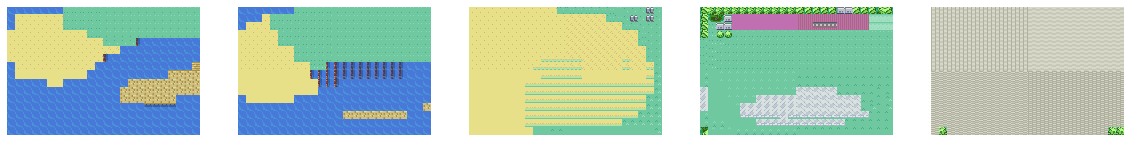

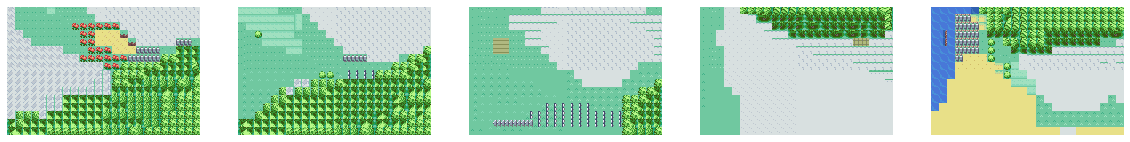

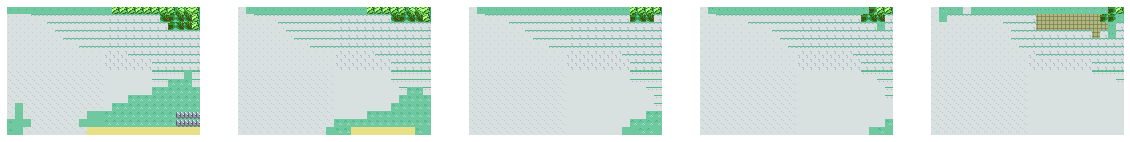

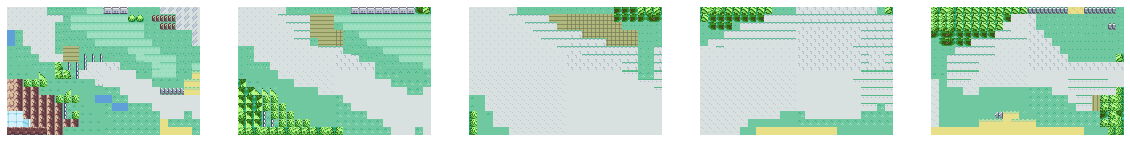

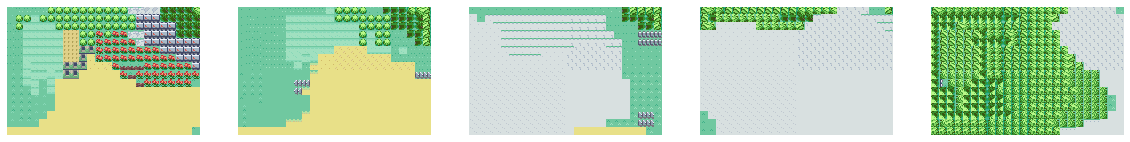

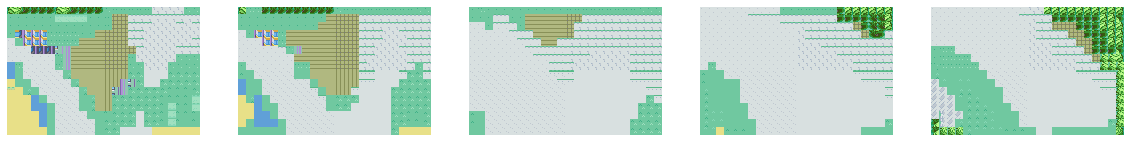

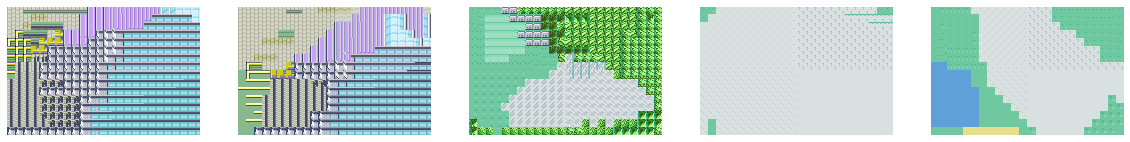

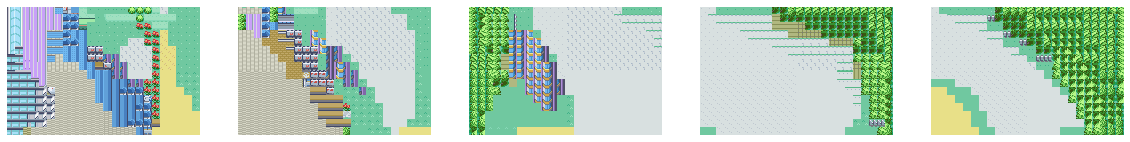

In [42]:
n = 5
latent_range = 3

for dim in range(latent_dim):
  plt.figure(figsize=(n * 4, 4))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    z_sample = np.zeros((latent_dim,))
    z_sample[dim] = (i - n / 2) / (n / 2) * latent_range
    z_sample = np.expand_dims(z_sample, 0)
    x_decoded = generator.predict(z_sample)
    chunk = decode_chunk(np.squeeze(x_decoded)) #remove batch dim
    plt.imshow(chunk)
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
  plt.show()

### Generation functions

In [0]:
def generate(latent):
  latent = np.expand_dims(latent, 0)
  encoded_chunk = generator.predict(latent)
  decoded_chunk = decode_chunk(np.squeeze(encoded_chunk))
  return decoded_chunk
  
def gen_random(mean=0, stdev=1):
  latent = np.random.normal(mean, stdev, (latent_dim,))
  chunk = generate(latent)
  
  return chunk, latent

#ok so here's how itll work:
#1: pick a random position from normal distribution (A)
#2: pick another random position from normal distribution (B)
#3: interpolate between A and B
#4: set A to B
#5: goto 2

def gen_interpolate(a, b, num_frames):
  chunks = []
  for i in range(num_frames):
    t = i / num_frames
    x = a + (b - a) * t
    chunk = generate(x)
    chunks.append(chunk)
  return chunks

import imageio
def save_random_video():
  a = np.random.normal(0, 1, (latent_dim,))
  b = np.random.normal(0, 1, (latent_dim,))
  
  aloc = np.round(a, 2).tostring()
  bloc = np.round(b, 2).tostring()
  print(aloc, bloc)
  #fn = "{} to {}.mp4".format(np.round(a, 2).tostring(), np.round(b, 2).tostring())
  fn = "a to b.mp4"
  frames = gen_interpolate(a, b, 120)
  
  imageio.mimwrite(fn, frames, fps = 30)

#TODO: generate the latent coords before generating chunks so we can batch...
def save_random_video(num_walks=1):
  a = np.random.normal(0, 1, (latent_dim,))
  
  frames = []
  for i in range(num_walks):
    b = np.random.normal(0, 1, (latent_dim,))
    frames += gen_interpolate(a, b, 120)
    a = b
    
  fn = "a to b.mp4"
  imageio.mimwrite(fn, frames, fps = 30)

def gen_zero():
  z_sample = np.array([[0, 0]]) #TODO: make this work with more than 2d.. like slice 2d at 0
  x_decoded = generator.predict(z_sample)
  chunk = decode_chunk(np.squeeze(x_decoded)) #remove batch dim
  return chunk, z_sample

def tile_count(chunk):
  ids = np.argmax(encode_chunk(chunk), axis=-1)
  return len(np.unique(ids))

### Generate random samples

Unique tiles: 34, latent: [ 5.90202698  8.43946093 -2.34371309  8.55095749  9.76694302  4.87253376
 13.6970571  -2.48065626]


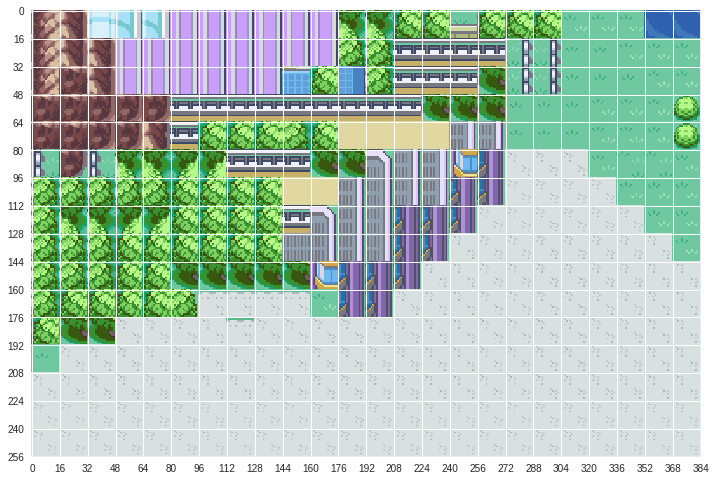

In [49]:
chunk, latent = gen_random(0, 10)
#chunk, latent = gen_zero()
print("Unique tiles: {}, latent: {}".format(tile_count(chunk), latent))

plt.figure(figsize=(12, 10))
plt.imshow(chunk)
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, chunk.shape[1] + 16, 16))
ax.yaxis.set_ticks(np.arange(0, chunk.shape[0] + 16, 16))
plt.show()

### Generate a movie

In [0]:
#generate a movie
#will be saved as a to b.mp4
save_random_video(10)